# test area

In [1]:
from pathlib import Path
import os, sys
import seaborn as sb
import pandas as pd
from datetime import datetime

from pandas_plots import tbl, pls, ven , hlp
# from pandas_plots.hlp import OperatingSystem
from connection_helper import sql
import duckdb as ddb

hlp.show_package_version(["matplotlib_venn", "dataframe_image", "plotly"], )
df = sb.load_dataset('taxis')
os.environ['THEME'] = 'light'

dir_db=Path("C://temp") if hlp.get_os(hlp.OperatingSystem.WINDOWS) else Path(os.path.expanduser("~/tmp"))

file_db_clin = dir_db/'2025-04-07_data_clin.duckdb'

print(hlp.get_os(hlp.OperatingSystem.MAC))

🐍 3.12.2 | 📦 matplotlib_venn: 0.11.10 | 📦 dataframe_image: 0.2.7 | 📦 plotly: 5.24.1 | 📦 pandas: 2.2.3 | 📦 numpy: 1.26.4 | 📦 duckdb: 1.2.2 | 📦 pandas-plots: 0.12.25 | 📦 connection-helper: 0.11.1
True


In [2]:
con = ddb.connect(file_db_clin, read_only=True)

In [3]:
db_delay = con.sql(f"""--sql
    select 
            first(z_kkr_label) as z_kkr_label,
            first(z_first_treatment_after_days) as z_first_treatment_after_days, 
            first(z_first_treatment) as z_first_treatment
    from Tumor
    where ifnull(z_first_treatment,'') <> ''
    and z_dy = 2023 and z_icd10_3d = 'C81'
    group by z_tum_id
    """)
tbl.descr_db(db_delay, caption="delay",)

🗄️ delay	1_632, 3
	("z_kkr_label, z_first_treatment_after_days, z_first_treatment")
┌─────────────┬──────────────────────────────┬───────────────────┐
│ z_kkr_label │ z_first_treatment_after_days │ z_first_treatment │
│   varchar   │            double            │      varchar      │
├─────────────┼──────────────────────────────┼───────────────────┤
│ 01-SH       │                         22.0 │ sy                │
│ 09-BY       │                         18.0 │ sy                │
│ 08-BW       │                         47.0 │ sy                │
└─────────────┴──────────────────────────────┴───────────────────┘



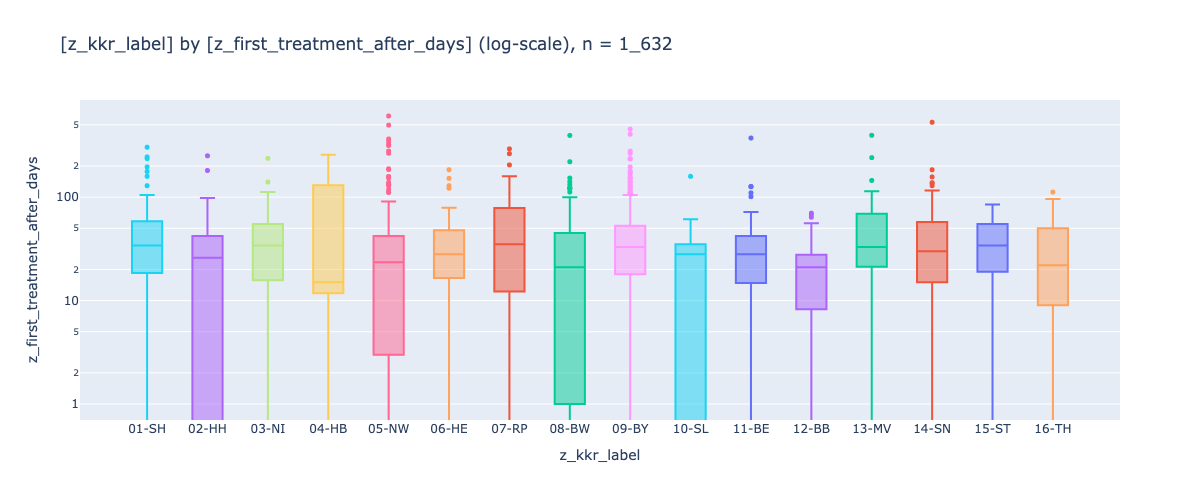

In [4]:
_ = pls.plot_boxes(
    # _df[["z_kkr_label", "z_first_treatment_after_days"]],
    db_delay.to_df().iloc[:,:2],
    height=500,
    annotations=False,
    use_log=True,
    summary=False,
    
)

In [5]:
db_delay.to_df().iloc[:,:2]

,z_kkr_label,z_first_treatment_after_days
0,09-BY,42.0
1,09-BY,14.0
2,14-SN,34.0
3,09-BY,50.0
4,05-NW,22.0
...,...,...
1627,11-BE,28.0
1628,08-BW,123.0
1629,08-BW,31.0
1630,16-TH,0.0


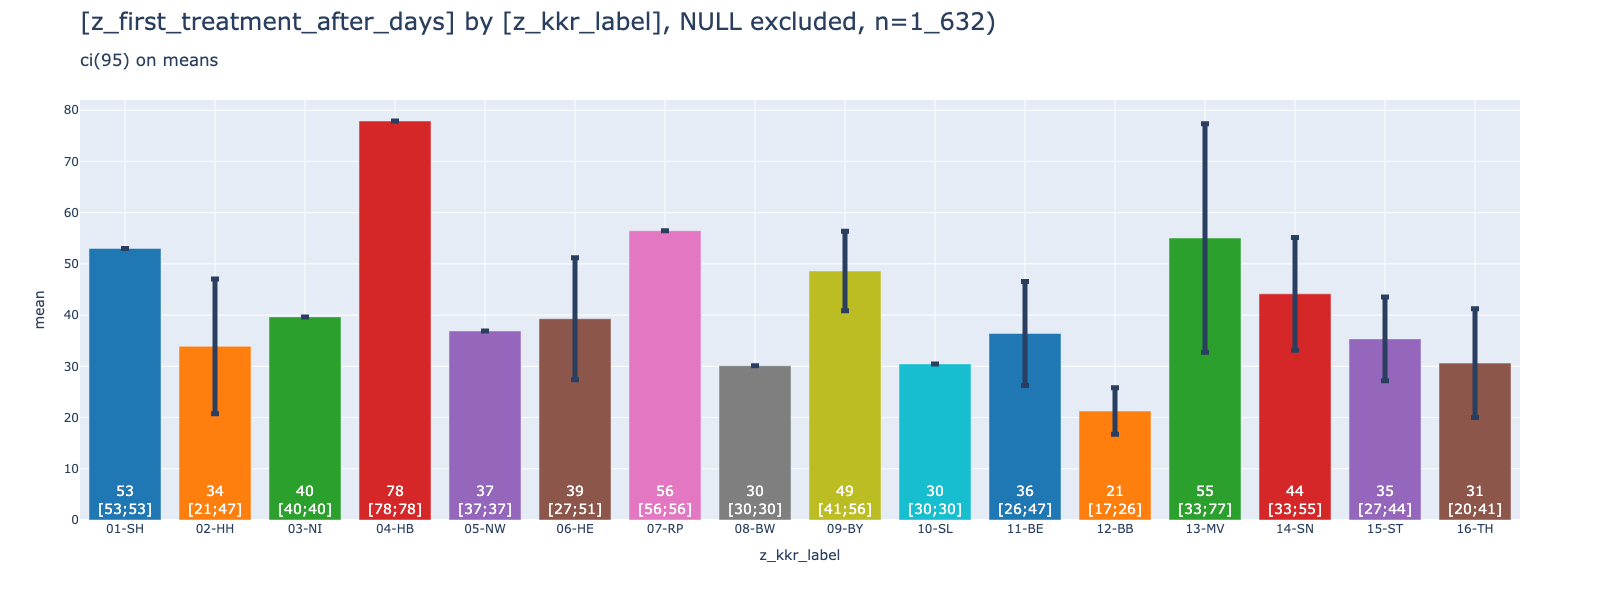

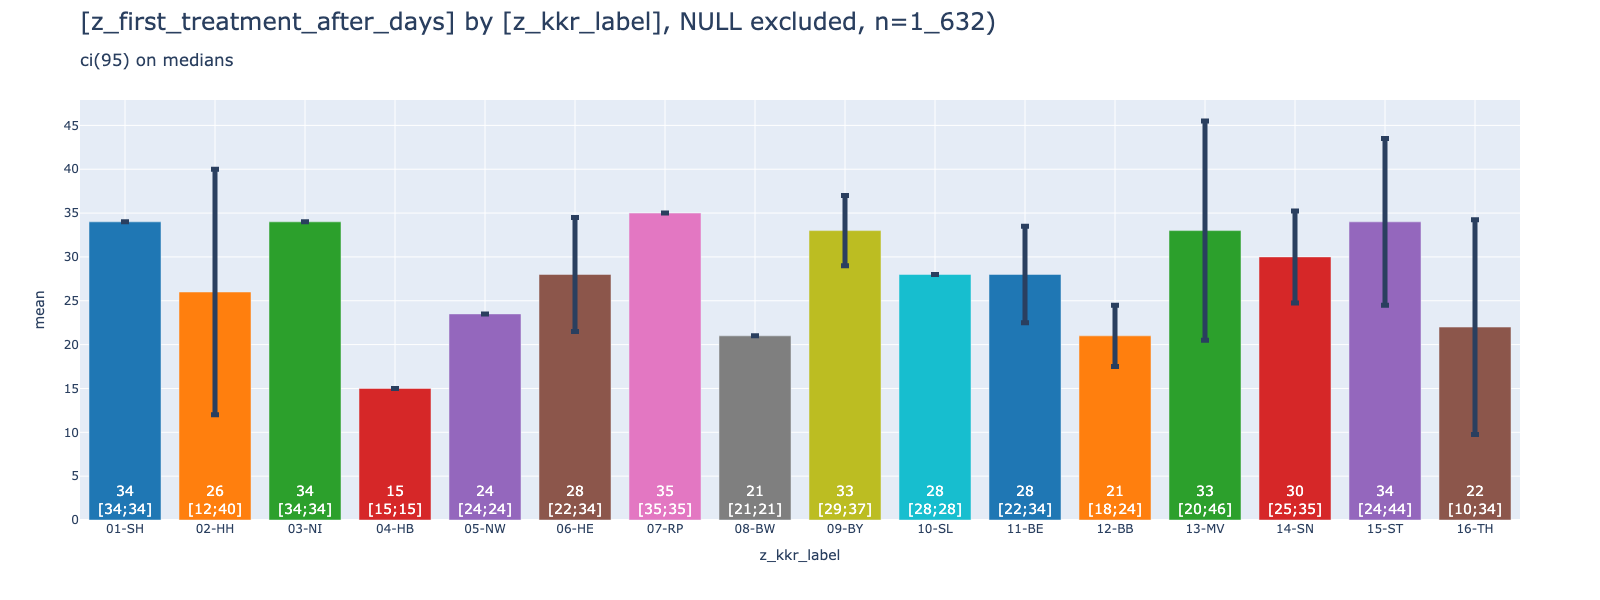

In [6]:
_ = pls.plot_bars(
    db_delay.to_df().iloc[:,:2],
    height=600,
    use_ci=True,
    # ci_agg='median',
)
_ = pls.plot_bars(
    db_delay.to_df().iloc[:,:2],
    height=600,
    use_ci=True,
    ci_agg='median',
)

In [7]:
con.close()
sys.exit(1)

SystemExit: 1

dropoff_borough     object
distance           float64
dtype: object

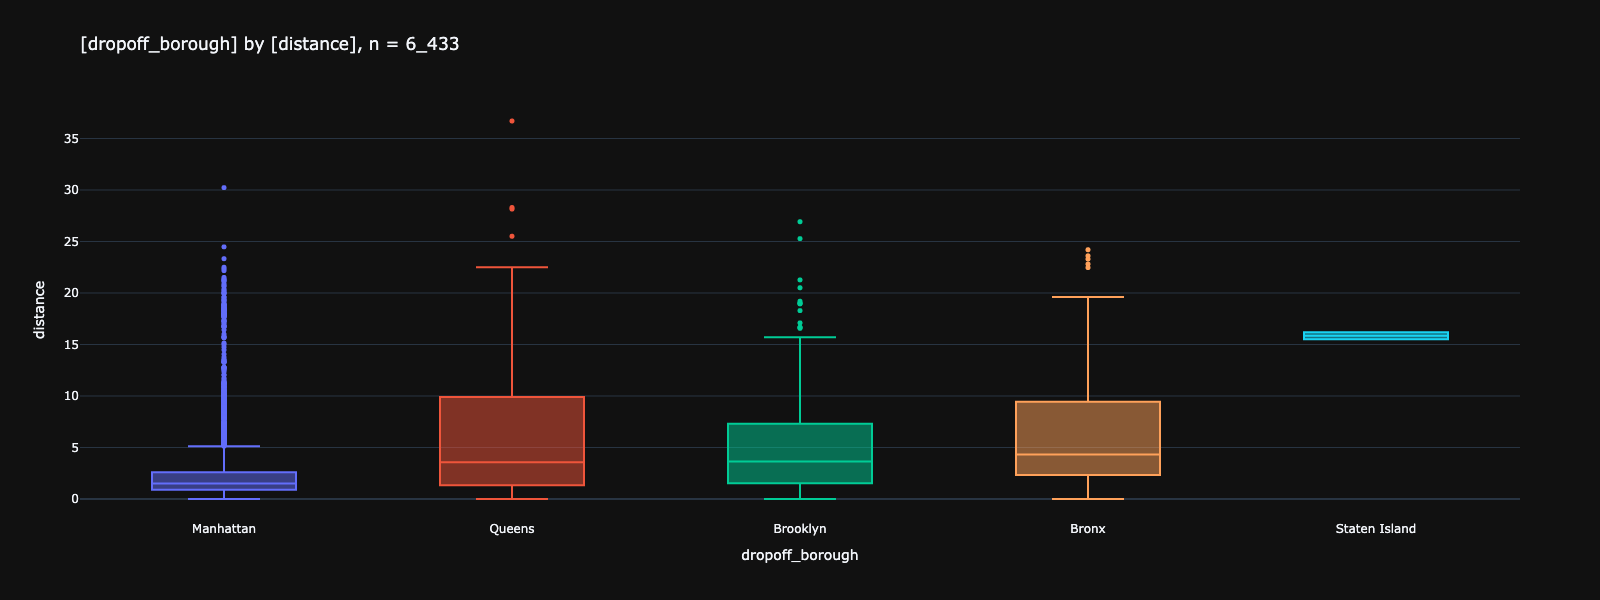

🟧 all data
distance -> min: 0.0 | lower: 0.0 | q25: 0.99 | median: 1.645 | mean: 2.9954 | q75: 3.2 | upper: 6.515 | max: 36.7 | std: 3.7207 | cv: 1.2421 | sum: 19_134.68 | skew: 2.885 | kurto: 9.7655  
🟧 boxes
Manhattan -> min: 0.0 | lower: 0.0 | q25: 0.91 | median: 1.5 | mean: 2.391 | q75: 2.6 | upper: 5.135 | max: 30.23 | std: 2.905 | cv: 1.215 | sum: 12_447.68 | skew: 3.7367 | kurto: 17.386  
Queens -> min: 0.0 | lower: 0.0 | q25: 1.335 | median: 3.56 | mean: 5.9596 | q75: 9.8875 | upper: 22.7162 | max: 36.7 | std: 5.8864 | cv: 0.9877 | sum: 3_230.13 | skew: 1.2906 | kurto: 1.4972  
Brooklyn -> min: 0.0 | lower: 0.0 | q25: 1.53 | median: 3.63 | mean: 5.0285 | q75: 7.3 | upper: 15.955 | max: 26.92 | std: 4.4884 | cv: 0.8926 | sum: 2_519.28 | skew: 1.4211 | kurto: 2.2301  
Bronx -> min: 0.0 | lower: 0.0 | q25: 2.36 | median: 4.31 | mean: 6.6123 | q75: 9.44 | upper: 20.06 | max: 24.2 | std: 5.9527 | cv: 0.9003 | sum: 905.88 | skew: 1.299 | kurto: 0.8808  
Staten Island -> min: 15.51 | 

In [ ]:
_df = df[["dropoff_borough", "distance"]]
display(_df.dtypes)
_=pls.plot_boxes(
    _df,
    width=1600,
    annotations=False,
    precision=4,
    box_width=0.5,
    # use_log=True,
)

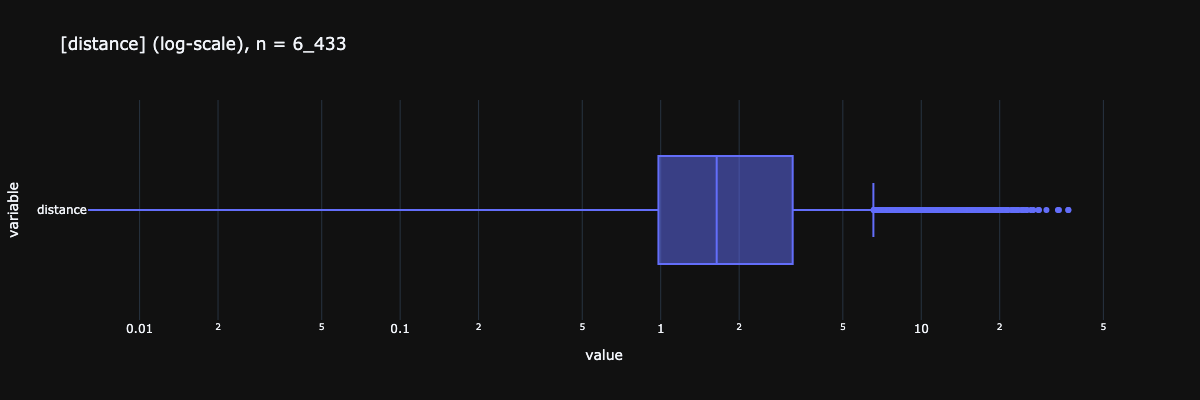

distance -> min: 0.0 | lower: 0.0 | q25: 0.98 | median: 1.64 | mean: 3.025 | q75: 3.21 | upper: 6.555 | max: 36.7 | std: 3.828 | cv: 1.266 | sum: 19_457.36 | skew: 3.008 | kurto: 11.135  


In [ ]:
_=pls.plot_box(
    df.distance,
    height=400,
    violin=False,
    x_min=-2,
    # x_max=50,
    use_log=True,
    annotations=False,
    # summary = False,
    # png_path=Path("box1.png"),
)

In [ ]:
hlp.add_measures_to_pyg_config(".local/pygwalker_spec_.json", strict=False)

In [ ]:
hlp.find_cols(df, [
    "tot",
    "dis",
    ])


['total', 'distance']

In [ ]:
_df = df[["passengers", "distance", "fare"]][:1]
tbl.show_num_df(
    _df,
    total_axis="xy",
    total_mode="mean",
    data_bar_axis="xy",
    pct_axis="",
    precision=2,
    total_exclude=False,
    show_as_pct=True,
    col1_width=100,
    # swap=True,
    # kpi_mode="",
    # kpi_mode="max_min_x",
    # kpi_rag_list=(1,7),
)

,passengers,distance,fare,Total
0,100.00%,160.00%,700.00%,320.00%
Total,100.00%,160.00%,700.00%,320.00%


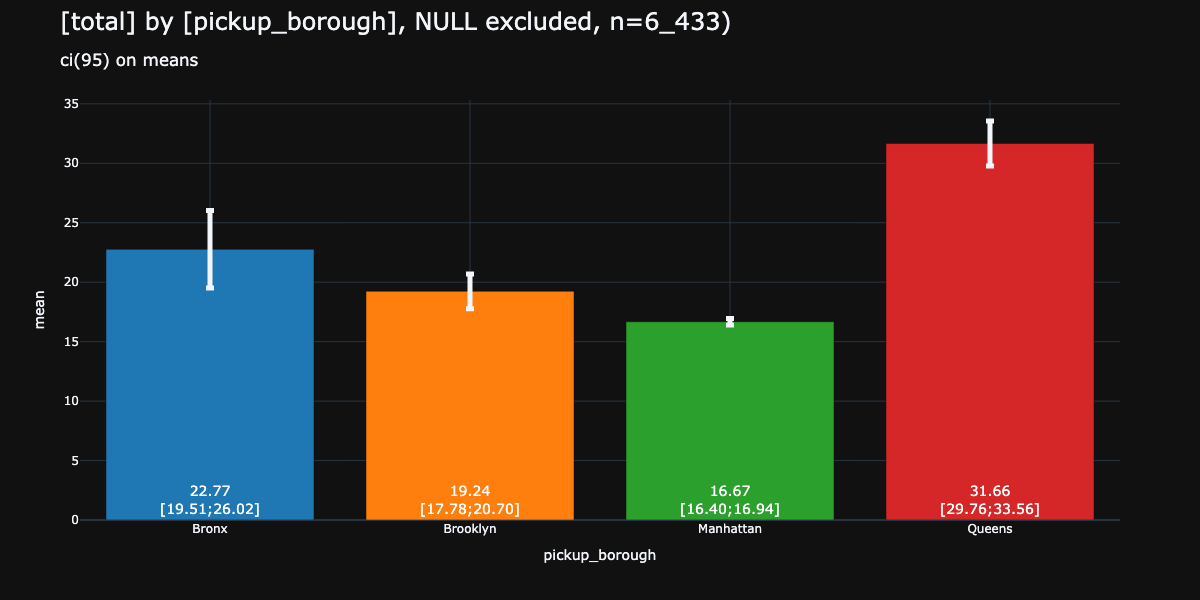

In [ ]:
_df = df[["pickup_borough", "total"]]
# _df
_ = pls.plot_bars(
    _df,
    height=600,
    width=1200,
    use_ci=True,
    # ci_agg="median",
    precision=2,
)

In [ ]:
_df["total"].sum()

119124.97

In [ ]:
# sys.exit(1)

🔵 *** df: taxis ***  
🟣 shape: (6_433, 4) columns: ['color' 'payment' 'pickup_borough' 'total']  
🟣 duplicates: 4_803  
🟣 uniques: [{color: 2 payment: 2 pickup_borough: 4 total: 898}]  
🟣 missings: [{color: 0 payment: 44 pickup_borough: 26 total: 0}]  
--- column uniques (all)  
🟠 index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,  
27, 28, 29,]  
🟠 color(2|object)   ['green', 'yellow',]  
🟠 payment(3|object)   ['<NA>', 'cash', 'credit card',]  
🟠 pickup_borough(5|object)   ['<NA>', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens',]  
🟠 total(898|float64)   [1.3, 3.3, 3.31, 3.8, 4.3, 4.8, 4.81, 5.0, 5.28, 5.3, 5.38, 5.55, 5.76, 5.8, 6.0, 6.05,  
6.09, 6.24, 6.3, 6.35, 6.36, 6.38, 6.8, 6.81, 6.85, 6.91, 6.95, 6.96, 7.0, 7.25,]  
--- column stats (numeric)  
total -> min: 1.3 | lower: 1.3 | q25: 10.8 | median: 14.16 | mean: 18.518 | q75: 20.3 | upper: 34.55 | max: 174.82 | std: 13.816 | cv: 0.746 | sum: 119_124.97 | skew: 3.093 | kurto: 15.

,color,payment,pickup_borough,total
0,yellow,credit card,Manhattan,12.95
1,yellow,cash,Manhattan,9.30
2,yellow,credit card,Manhattan,14.16


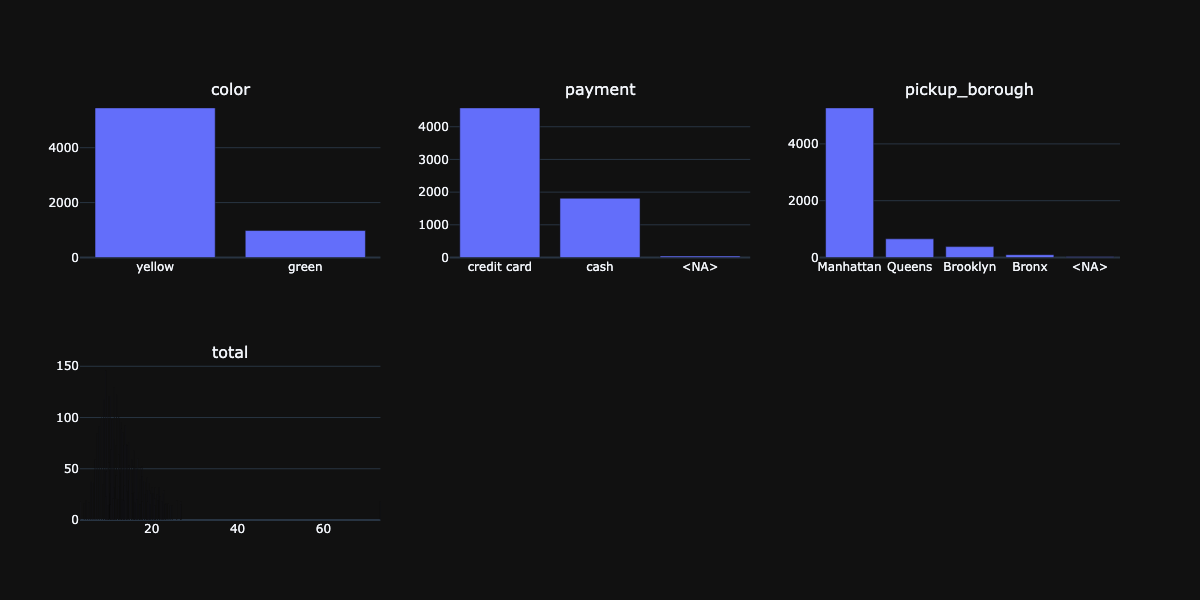

In [ ]:
_df = df[["color","payment","pickup_borough","total"]]
_df
# _=pls.plot_stacked_bars(_df[["color","payment","total"]],)
tbl.describe_df(_df, "taxis")

In [ ]:
df_dsich = pd.read_csv("assets/dsich.csv", sep=";")#.astype({"z_dy": "Int64"}).astype({"z_dy": str})
display(df_dsich[:3])
# print(df_dsich.dtypes)

,id,bl,label,cnt
0,0,01-SH,7 - Histologie Primärtumor,14351
1,22,01-SH,3 - Todesbescheinigung (DCO),1004
2,23,01-SH,5 - Zytologie,146


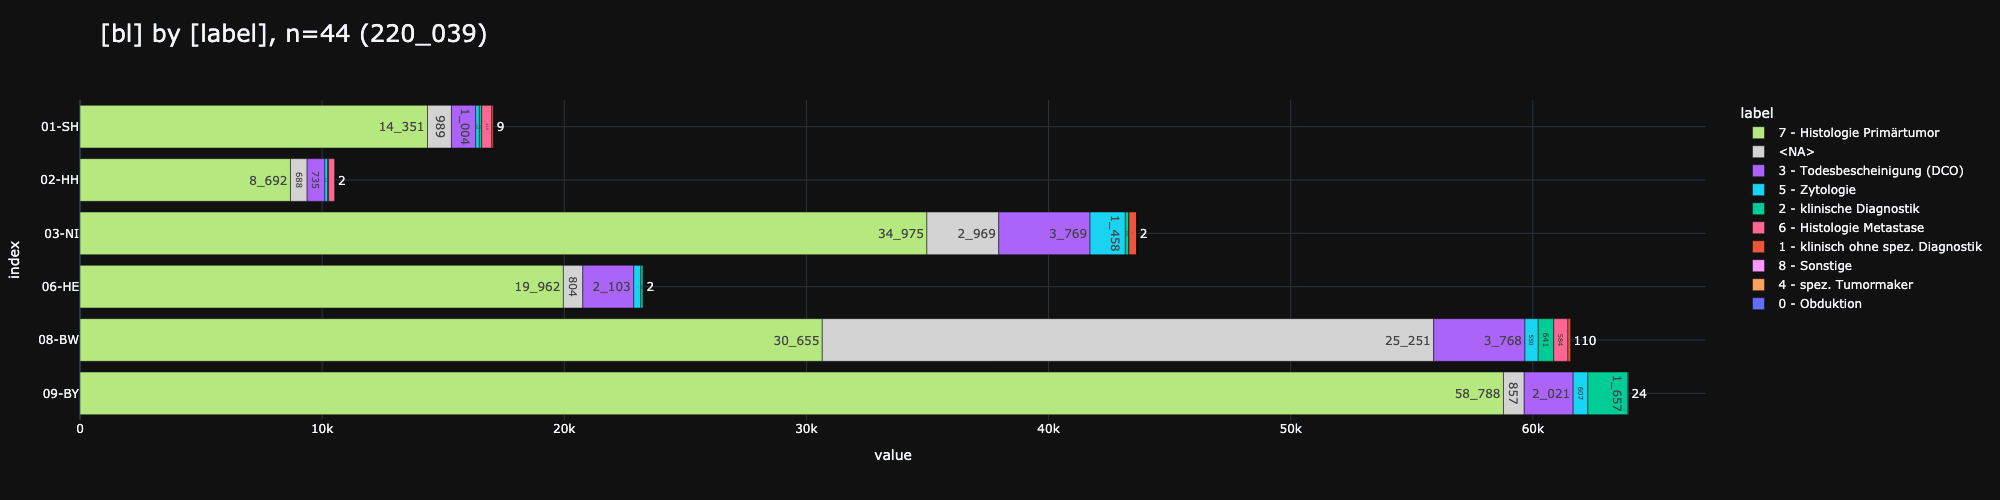

In [ ]:
_df = df_dsich[
    [
        "bl",
        "label",
        "cnt",
    ]
].sort_values("bl")

_ = pls.plot_stacked_bars(
    _df,
    # swap=True,
    orientation="h",
    # show_total=True,
    # normalize=True,
    # relative=True,
    # height=1000,
    # top_n_color=5,
    # sort_values_index=True,
    sort_values_color=True,
    # top_n_index=3,
    # precision=2,
    # show_other=True,
    # top_n_index=2,
)
_

In [ ]:
df_facets = pd.read_csv("assets/facets.csv", sep=";")#.astype({"z_dy": "Int64"}).astype({"z_dy": str})
display(df_facets[:None])
print(df_facets.dtypes)

,z_dy,tu,z_kkr_label,cnt
0,2020,06,13-MV,1
1,2020,30,13-MV,1
2,2020,###,13-MV,21
3,2020,18,11-BE,1
4,2020,18.,13-MV,1
...,...,...,...,...
16352,2023,S37,14-SN,1
16353,2023,S72,11-BE,1
16354,2023,Z22,14-SN,1
16355,2023,Z85,14-SN,1


z_dy            int64
tu             object
z_kkr_label    object
cnt             int64
dtype: object


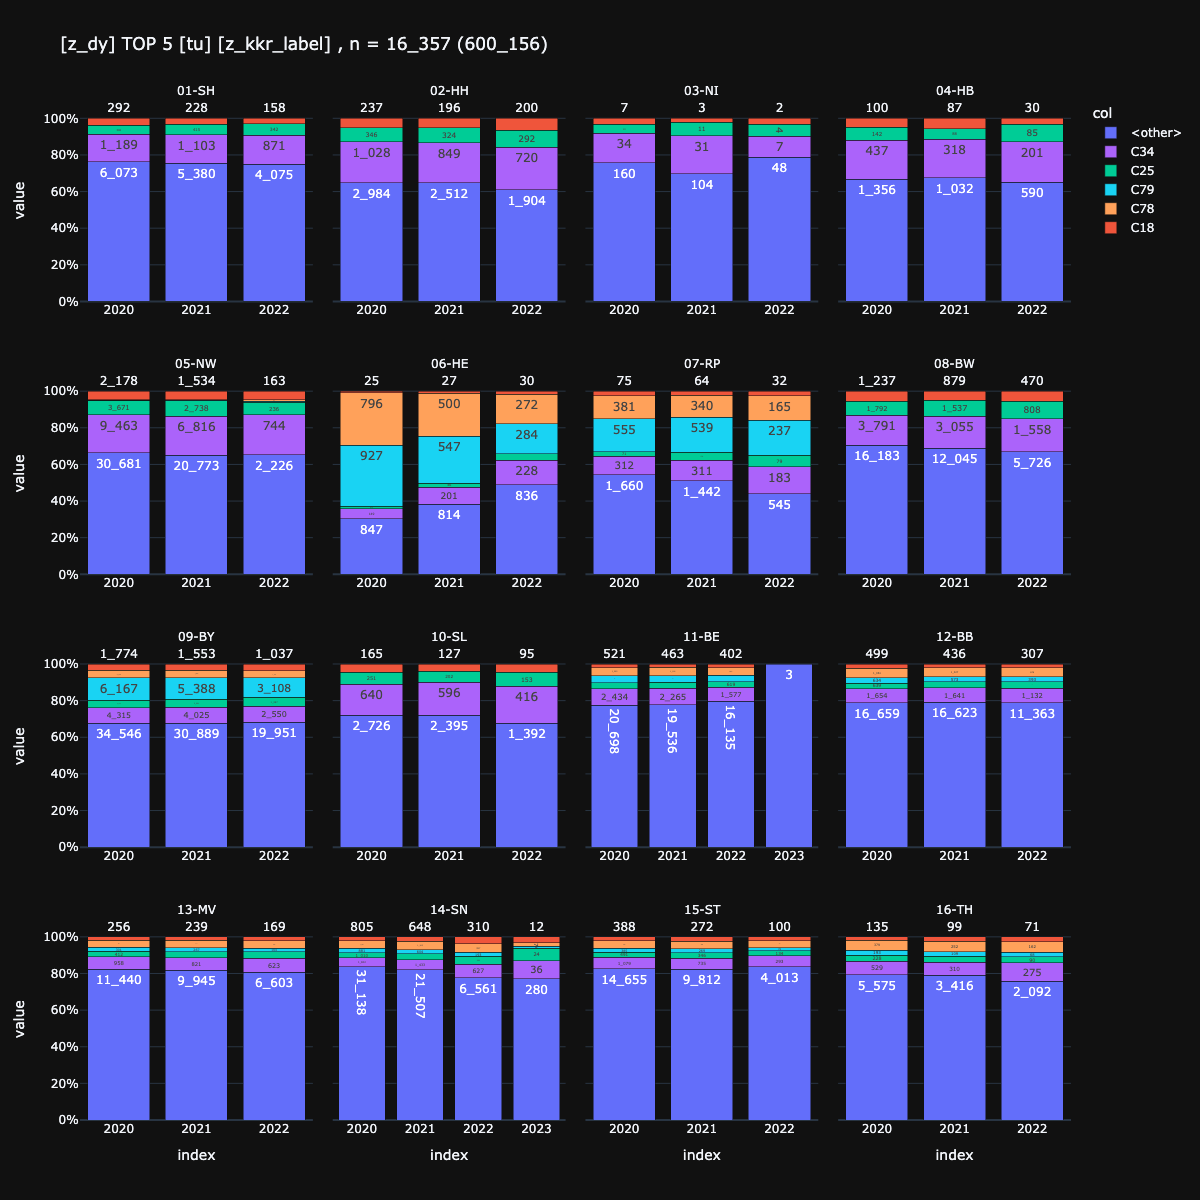

In [ ]:
_df = df_facets[
    [
        "z_dy",
        "tu",
        "z_kkr_label",
        "cnt",
    ]
]#[:100]
# _df


l=pls.plot_facet_stacked_bars(
    _df,
    top_n_color=5,
    # subplots_per_row=3,
    # top_n_facet=15,
    # top_n_index=3, 
    show_other=True,
    sort_values_color=True,
    # sort_values_facet=True,
    relative=True,
    # show_pct=True,
    annotations=True,
    )
# l

# ll = pls.plot_facet_stacked_bars(
#     _df,
#     top_n_color=5,
#     # subplots_per_row=8,
#     # top_n_facet=15,
#     # top_n_index=3, 
#     show_other=True,
#     sort_values_color=True,
#     # sort_values_facet=True,
#     relative=True,
#     annotations=True,
#     )
# # ll

In [ ]:
sys.exit(1)

SystemExit: 1

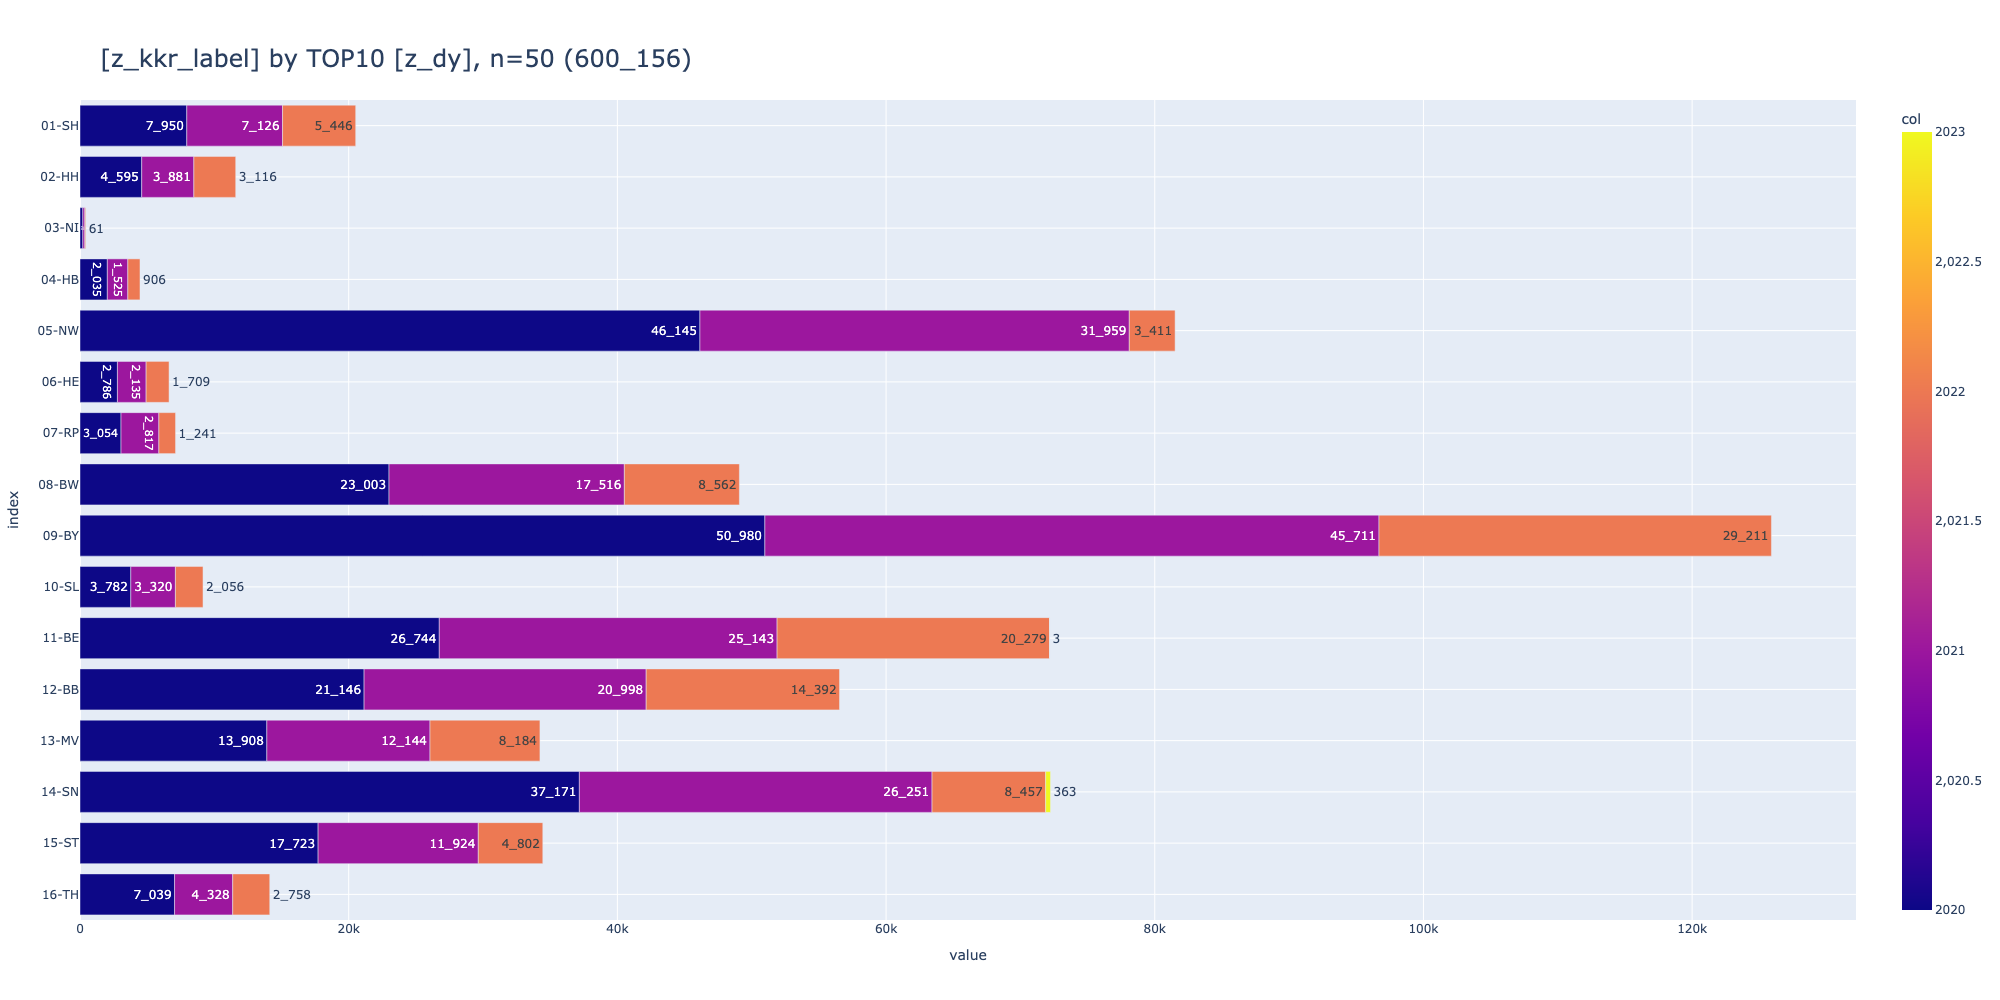

In [ ]:
_df = df_facets[
    [
        "z_kkr_label",
        "z_dy",
        "cnt",
    ]
]#.astype({"z_dy": str})

_ = pls.plot_stacked_bars(
    _df,
    # swap=True,
    orientation="h",
    # show_total=True,
    # normalize=True,
    # relative=True,
    height=1000,
    top_n_color=10,
    # sort_values_index=True,
    # sort_values_color=True,
    # top_n_index=5,
    # precision=2,
    # show_other=True,
    # top_n_index=2,
)
_

In [ ]:
sys.exit(1)


SystemExit: 1

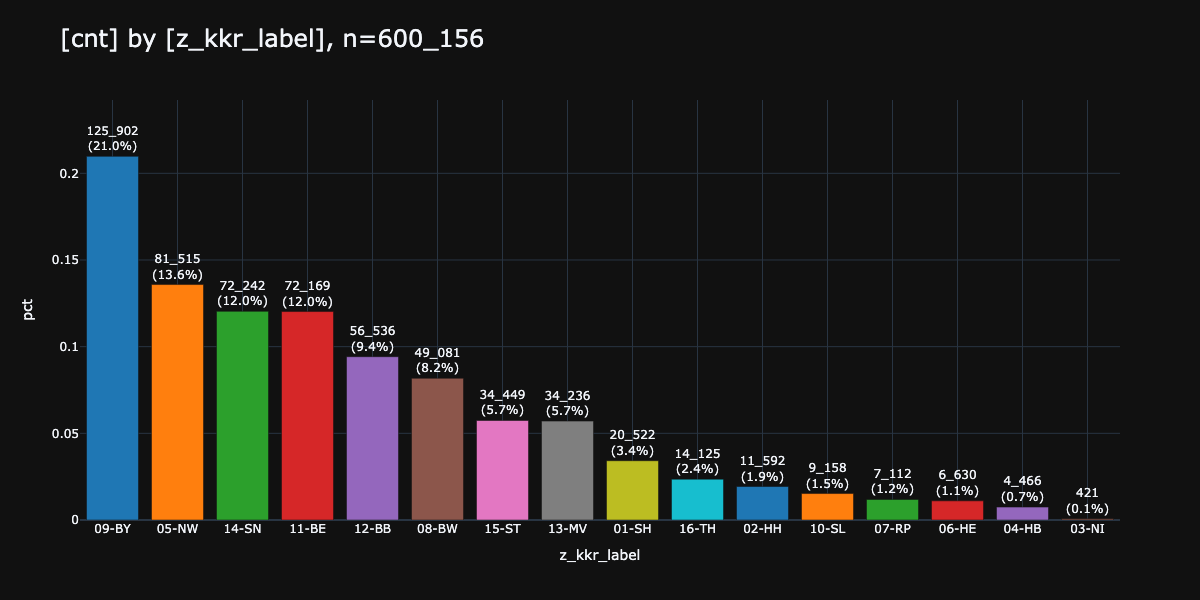

In [ ]:
_df = df_facets[
    [
        "z_kkr_label",
        "cnt",
    ]
]
_df

_=pls.plot_bars(_df, height=600, width=1200, sort_values=True)

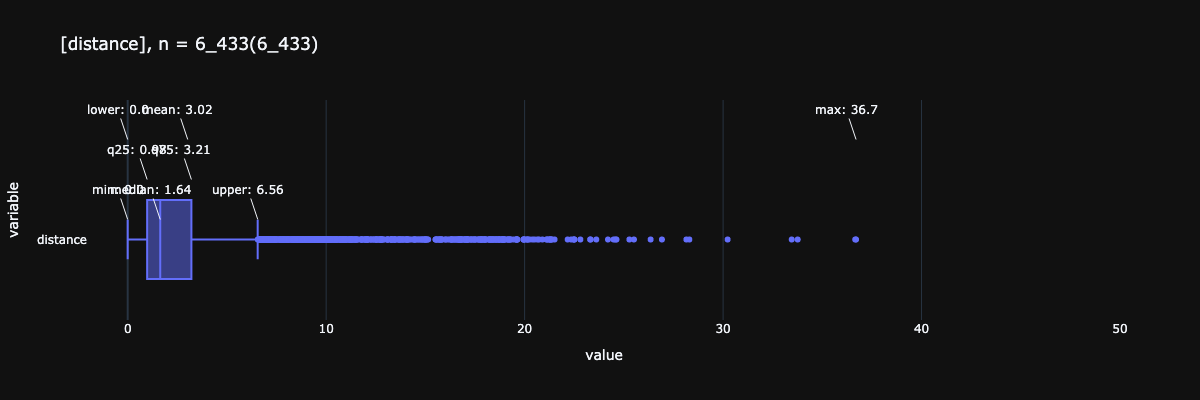

distance -> min: 0.0 | lower: 0.0 | q25: 0.98 | median: 1.64 | mean: 3.025 | q75: 3.21 | upper: 6.555 | max: 36.7 | std: 3.828 | cv: 1.266 | sum: 19_457.36 | skew: 3.008 | kurto: 11.135


In [ ]:
_=pls.plot_box(
    df.distance,
    height=400,
    violin=False,
    x_min=-2,
    x_max=50,
    # summary = False,
    # png_path=Path("box1.png"),
)

dropoff_borough     object
distance           float64
dtype: object

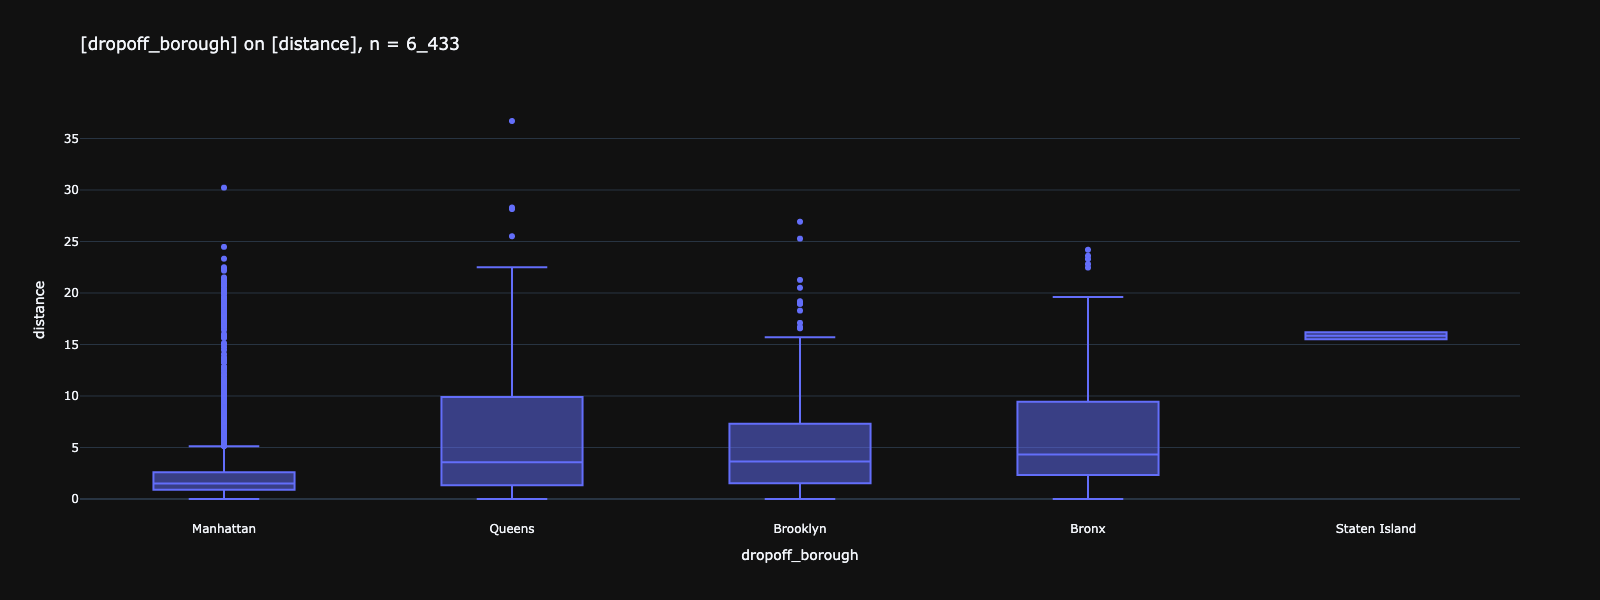

🟧 all data
distance -> min: 0.0 | lower: 0.0 | q25: 0.99 | median: 1.645 | mean: 2.9954 | q75: 3.2 | upper: 6.515 | max: 36.7 | std: 3.7207 | cv: 1.2421 | sum: 19_134.68 | skew: 2.885 | kurto: 9.7655
🟧 boxes
Manhattan -> min: 0.0 | lower: 0.0 | q25: 0.91 | median: 1.5 | mean: 2.391 | q75: 2.6 | upper: 5.135 | max: 30.23 | std: 2.905 | cv: 1.215 | sum: 12_447.68 | skew: 3.7367 | kurto: 17.386
Queens -> min: 0.0 | lower: 0.0 | q25: 1.335 | median: 3.56 | mean: 5.9596 | q75: 9.8875 | upper: 22.7162 | max: 36.7 | std: 5.8864 | cv: 0.9877 | sum: 3_230.13 | skew: 1.2906 | kurto: 1.4972
Brooklyn -> min: 0.0 | lower: 0.0 | q25: 1.53 | median: 3.63 | mean: 5.0285 | q75: 7.3 | upper: 15.955 | max: 26.92 | std: 4.4884 | cv: 0.8926 | sum: 2_519.28 | skew: 1.4211 | kurto: 2.2301
Bronx -> min: 0.0 | lower: 0.0 | q25: 2.36 | median: 4.31 | mean: 6.6123 | q75: 9.44 | upper: 20.06 | max: 24.2 | std: 5.9527 | cv: 0.9003 | sum: 905.88 | skew: 1.299 | kurto: 0.8808
Staten Island -> min: 15.51 | lower: 15.

In [ ]:
_df = df[["dropoff_borough", "distance"]]
display(_df.dtypes)
_=pls.plot_boxes(
    _df,
    width=1600,
    annotations=False,
    precision=4,
    
)

,color,dropoff_borough,payment
0,yellow,Manhattan,credit card
1,yellow,Manhattan,cash
2,yellow,Manhattan,credit card
3,yellow,Manhattan,credit card
4,yellow,Manhattan,credit card
...,...,...,...
6428,green,Manhattan,credit card
6429,green,Bronx,credit card
6430,green,Brooklyn,cash
6431,green,Brooklyn,credit card


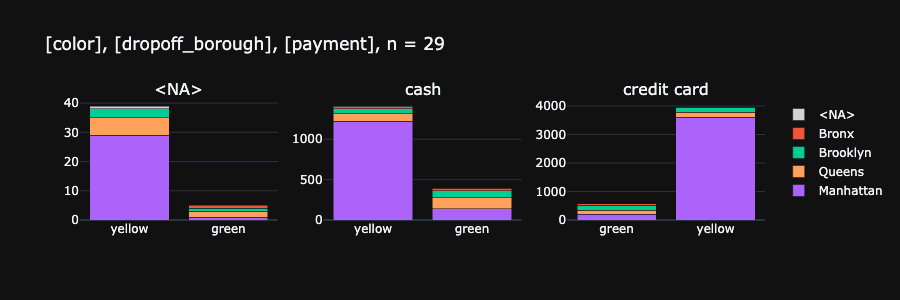

In [ ]:

_df2 = df[
    [
        "color",
        "dropoff_borough", 
        "payment",
        # "total"
    ]]

display(_df2)

l=pls.plot_facet_stacked_bars(
    _df2, 
    # top_n_columns=2,
    # subplots_per_row=2,
    )

In [ ]:
import rpy2.robjects as ro
import pandas as pd

# Activate pandas-to-R conversion
ro.pandas2ri.activate()

# Install the networkD3 package if it's not already installed
ro.r('if (!require("networkD3")) install.packages("networkD3")')

# Create a simple pandas DataFrame for the Sankey diagram
data = pd.DataFrame({
    'source': ['A', 'A', 'B', 'C'],
    'target': ['B', 'C', 'C', 'D'],
    'value': [10, 20, 30, 40]
})

# Convert the pandas DataFrame to an R DataFrame
r_data = ro.pandas2ri.py2rpy(data)

# Pass the R DataFrame to the global environment
ro.globalenv['r_data'] = r_data

# R code for creating a Sankey diagram
r_code = '''
# if (!require("ggsankey")) 
install.packages("ggsankey")
library(ggsankey)

# Create a simple dataset for the Sankey diagram
# The data represents flows from one node to another with values
data <- data.frame(
    source = c("A", "A", "B", "C"),
    target = c("B", "C", "C", "D"),
    value = c(10, 20, 30, 40)
)

# Plot the Sankey diagram using ggsankey
ggplot(data, aes(x = source, xend = target, y = value, yend = value, fill = source)) +
    geom_sankey(flow.alpha = 0.6, node.size = 10) +
    geom_text(aes(
        x = (as.numeric(source) + as.numeric(target)) / 2,
        y = value, label = value
    ), color = "black", size = 5, fontface = "bold") +
    theme_void() +
    ggtitle("Sankey Diagram with Numbers Visible")
'''

# Execute the R code
ro.r(r_code)


R[write to console]: Installing package into ‘/opt/homebrew/lib/R/4.4/site-library’
(as ‘lib’ is unspecified)

R[write to console]: Error in library(ggsankey) : there is no package called ‘ggsankey’

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package ‘ggsankey’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages 



RRuntimeError: Error in library(ggsankey) : there is no package called ‘ggsankey’


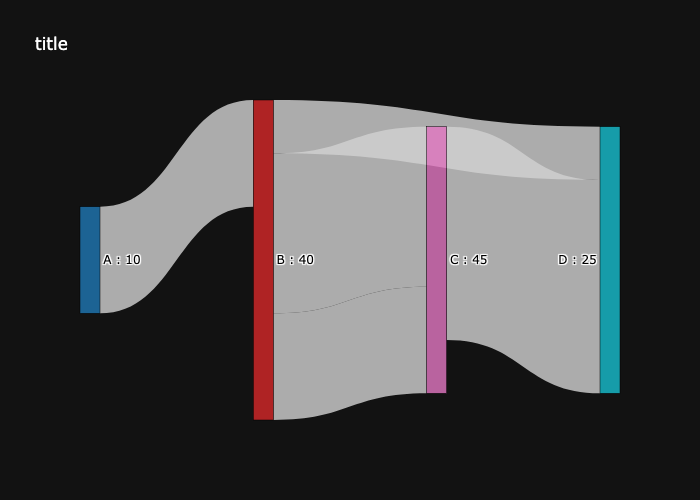

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import os
import matplotlib.pyplot as plt

def create_sankey_from_df(df, show_numbers=False, renderer=None):
    """
    Creates a basic Sankey diagram from a DataFrame with exactly 3 columns: source, target, and value.
    Switches between dark and light mode based on the 'THEME' environment variable.
    The flow (bars) are colored light grey, while nodes use the 'tab10' color palette.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the flow data. Must have 3 columns: 'source', 'target', and 'value'.
        show_numbers (bool): If True, the flow values will be displayed on the nodes (bars).
        renderer (str or None): Renderer for displaying the plot (e.g., 'png', 'svg', or None).
    
    Returns:
        plotly.graph_objects.Figure: The Sankey diagram plot.
    """
    
    # Get the theme from the environment variable
    theme = os.getenv("THEME", "light").lower()
    if theme not in ["dark", "light"]:
        theme = "light"  # Default to light mode if the theme is not set or invalid
    
    # Check if the DataFrame has exactly 3 columns
    if df.shape[1] != 3:
        raise ValueError("DataFrame must have exactly 3 columns: 'source', 'target', and 'value'.")
    
    # Ensure the column names are 'source', 'target', and 'value'
    df.columns = ['source', 'target', 'value']
    
    # Ensure correct types: source and target should be strings, value should be numeric
    if not df['source'].dtype == 'object':
        raise TypeError("'source' column must contain strings.")
    if not df['target'].dtype == 'object':
        raise TypeError("'target' column must contain strings.")
    if not pd.api.types.is_numeric_dtype(df['value']):
        raise TypeError("'value' column must contain numeric values.")
    
    # Create a list of unique node labels from both source and target columns
    node_labels = list(pd.concat([df['source'], df['target']]).unique())
    
    # Create a dictionary for mapping node names to indices
    node_index = {label: index for index, label in enumerate(node_labels)}

    # Map source and target values to their corresponding indices
    df['source_idx'] = df['source'].map(node_index)
    df['target_idx'] = df['target'].map(node_index)

    # Light grey color for the links (flow)
    link_colors = ['rgba(211, 211, 211, 0.8)'] * len(df)  # Light grey

    # Use a cyclic color palette like tab10 for the nodes
    tab10_palette = plt.cm.get_cmap('tab10', len(node_labels))
    node_colors = [f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 0.8)' 
                   for r, g, b, _ in [tab10_palette(i) for i in range(len(node_labels))]]

    # Calculate the sum of incoming and outgoing flows for each node if show_numbers is True
    if show_numbers:
        node_flow_values = df.groupby('source')['value'].sum().add(df.groupby('target')['value'].sum(), fill_value=0)
        node_labels = [f"{label} : {int(node_flow_values.get(label, 0))}" for label in node_labels]

    # Create the Sankey diagram
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,  # Padding between nodes
            thickness=20,  # Node thickness
            line=dict(color="black", width=0.5),
            label=node_labels,  # Labels for the nodes with flow values if show_numbers is True
            color=node_colors  # Node colors using the 'tab10' palette
        ),
        link=dict(
            source=df['source_idx'],  # Source node indices
            target=df['target_idx'],  # Target node indices
            value=df['value'],  # Flow values
            color=link_colors,  # Light grey color for links
            hoverinfo="none"  # No hover info for the links (we are showing the numbers directly)
        )
    ))

    # Apply the selected theme
    if theme == "dark":
        fig.update_layout(
            paper_bgcolor='rgb(18, 18, 18)',  # Dark background
            plot_bgcolor='rgb(18, 18, 18)',   # Dark background for plot
            font=dict(color='white'),  # White font for dark mode
            title=dict(font=dict(color='white'))  # Title font color
        )
    else:  # Light mode
        fig.update_layout(
            paper_bgcolor='rgb(255, 255, 255)',  # Light background
            plot_bgcolor='rgb(255, 255, 255)',   # Light background for plot
            font=dict(color='black'),  # Black font for light mode
            title=dict(font=dict(color='black'))  # Title font color
        )

    fig.update_layout(
        title_text="title",
        font_color="Black",
        # font_size=12,
    )

    # Show the diagram with the selected renderer
    fig.show(renderer=renderer)

# Example usage
data = {
    'source': ['A', 'B', 'B', 'B', 'C'],
    'target': ['B', 'C', 'D', 'C', 'D'],
    'value': [10, 15, 5, 10, 20]
}

# Create a DataFrame from the example data
df = pd.DataFrame(data)

# Create a Sankey diagram from the DataFrame with numbers shown and rendered as PNG
create_sankey_from_df(df, show_numbers=True, renderer="png")


In [ ]:
lol =tbl.print_summary(df, show=False)
lol#.get("lower")

{'min': 1.3,
 'lower': 1.3,
 'q25': 10.8,
 'median': 14.16,
 'mean': 18.518,
 'q75': 20.3,
 'upper': 34.55,
 'max': 174.82,
 'std': 13.816,
 'cv': 0.746,
 'sum': 119124.97,
 'skew': 3.093,
 'kurto': 15.053}

In [ ]:
_df = df[["color","payment","pickup_borough","total"]]
_df
# _=pls.plot_stacked_bars(_df[["color","payment","total"]],)
tbl.describe_df(_df, "taxis")

🔵 *** df: taxis ***
🟣 shape: (6_433, 4) columns: ['color' 'payment' 'pickup_borough' 'total'] 
🟣 duplicates: 4_803
🟣 uniques: [{color: 2 payment: 2 pickup_borough: 4 total: 898}]
🟣 missings: [{color: 0 payment: 44 pickup_borough: 26 total: 0}]
--- column uniques (all)
🟠 index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 
27, 28, 29,]
🟠 color(2|object) ['green', 'yellow',]
🟠 payment(3|object) ['<NA>', 'cash', 'credit card',]
🟠 pickup_borough(5|object) ['<NA>', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens',]
🟠 total(898|float64) [1.3, 3.3, 3.31, 3.8, 4.3, 4.8, 4.81, 5.0, 5.28, 5.3, 5.38, 5.55, 5.76, 5.8, 6.0, 6.05, 
6.09, 6.24, 6.3, 6.35, 6.36, 6.38, 6.8, 6.81, 6.85, 6.91, 6.95, 6.96, 7.0, 7.25,]
--- column stats (numeric)


AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
_ = pls.plot_facet_stacked_bars(
    _df,
    # subplots_per_row=1,
    top_n_index=5,
    top_n_columns=3,
    top_n_facet=4,
    null_label="<NA>",
    subplot_size=400,
    color_palette="Light24",
    caption="Taxi Data Analysis:",
    renderer=None,
    annotations=True,
    # precision=0,
    # png_path="taxis_stacked_barchart.png",  # Optional save path
)

In [ ]:
from pandas_plots.hlp import to_series

df.pickup.to_series()

0      2019-03-23 20:21:09
1      2019-03-04 16:11:55
2      2019-03-27 17:53:01
3      2019-03-10 01:23:59
4      2019-03-30 13:27:42
               ...        
6428   2019-03-31 09:51:53
6429   2019-03-31 17:38:00
6430   2019-03-23 22:55:18
6431   2019-03-04 10:09:25
6432   2019-03-13 19:31:22
Name: pickup, Length: 6433, dtype: datetime64[ns]

In [ ]:
db = con.from_df(df)
tbl.descr_db(db, caption="taxis",)

🗄️ taxis	6_433, 14
	("pickup, dropoff, passengers, distance, fare, tip, tolls, total, color, payment, pickup_zone, dropoff_zone, pickup_borough, dropoff_borough")
┌─────────────────────┬─────────────────────┬────────────┬──────────┬────────┬────────┬────────┬────────┬─────────┬─────────────┬───────────────────────┬───────────────────────┬────────────────┬─────────────────┐
│       pickup        │       dropoff       │ passengers │ distance │  fare  │  tip   │ tolls  │ total  │  color  │   payment   │      pickup_zone      │     dropoff_zone      │ pickup_borough │ dropoff_borough │
│    timestamp_ns     │    timestamp_ns     │   int64    │  double  │ double │ double │ double │ double │ varchar │   varchar   │        varchar        │        varchar        │    varchar     │     varchar     │
├─────────────────────┼─────────────────────┼────────────┼──────────┼────────┼────────┼────────┼────────┼─────────┼─────────────┼───────────────────────┼───────────────────────┼────────────────┼────

In [ ]:
_=tbl.print_summary(df)

passengers min: 0 | lower: 0 | q25: 1.0 | median: 1.0 | mean: 1.544 | q75: 2.0 | upper: 3.5 | max: 6 | std: 1.208 | cv: 0.782 | sum: 9_791 | skew: 2.349 | kurto: 4.812
distance min: 0.0 | lower: 0.0 | q25: 0.99 | median: 1.65 | mean: 2.998 | q75: 3.2 | upper: 6.515 | max: 36.7 | std: 3.72 | cv: 1.241 | sum: 19_008.46 | skew: 2.886 | kurto: 9.784
fare min: 1.0 | lower: 1.0 | q25: 6.5 | median: 9.5 | mean: 12.888 | q75: 15.0 | upper: 27.75 | max: 150.0 | std: 10.722 | cv: 0.832 | sum: 81_722.37 | skew: 2.606 | kurto: 10.162
tip min: 0.0 | lower: 0.0 | q25: 0.0 | median: 1.75 | mean: 1.973 | q75: 2.82 | upper: 7.05 | max: 23.19 | std: 2.362 | cv: 1.197 | sum: 12_508.91 | skew: 2.295 | kurto: 8.073
tolls min: 0.0 | lower: 0.0 | q25: 0.0 | median: 0.0 | mean: 0.315 | q75: 0.0 | upper: 0.0 | max: 24.02 | std: 1.369 | cv: 4.349 | sum: 1_996.1 | skew: 4.875 | kurto: 32.133
total min: 1.3 | lower: 1.3 | q25: 10.8 | median: 14.16 | mean: 18.31 | q75: 20.3 | upper: 34.55 | max: 174.82 | std: 12.9

In [ ]:
tbl.describe_df(
    df,
    "test",
    use_plot=True,
    use_columns=True,
    use_missing=True,
)

In [ ]:
# sys.exit()


In [ ]:
# Example data: names and corresponding dates
data = ["Alice", "Bob", "Charlie", "Dr. David", "DrEve lol 23.05.2020", None, ""]
_df = pd.DataFrame(data, columns=['Data'])
_df['New_Column'] = [10, 20, 30, 40, 50, 60, 70]

# Print the Series
print(_df)

_ = pii.remove_pii(_df['Data'], logging=True, verbose=True,custom_regex=r"Bob")
_df.drop(axis=0, index=_, inplace=False)

In [ ]:
# hlp.get_os(OperatingSystem.MAC)

## describe

In [ ]:

tbl.describe_df(df, 'dataframe', top_n_uniques=5, top_n_chars_in_index=5)
# lol=txt.wrap(list(df['passengers'].sort_values().value_counts().index), max_items_in_line=40)
# lol=wrap('kldjfldjfljö', max_items_in_line=40)
# lol=list(df['passengers'].value_counts().sort_index().index)[:3]
# lol
# txt.wrap(lol)

## show num

In [ ]:
from pathlib import Path

_df=df.pivot_table(index="color", columns="payment", values="fare", aggfunc="sum", dropna=False)
tbl.show_num_df(
    _df,
    total_mode="sum",
    total_axis="y",
    data_bar_axis="",
    pct_axis="xy",
    precision=0,
    heatmap_axis="xy",
    # kpi_mode="max_min_x",
    total_exclude=True,
    # kpi_mode="min_max_xy",
    kpi_mode="rag_abs",
    kpi_rag_list=(100, 1000),
    # swap=True,
    font_size_td=12,
    font_size_th=14,
    png_path=Path("test.png"),
)

In [ ]:
_df=df[["color", "payment", "fare"]]
tbl.pivot_df(
    _df,
    total_mode="sum",
    data_bar_axis="xy",
    pct_axis="xy",
    precision=0,
    heatmap_axis="",
    kpi_mode="max_min_x"
    # kpi_mode="min_max_xy",
    # kpi_mode="rag_abs",
    # kpi_rag_list=(100, 1000),
)

In [ ]:
_df = df[["distance", "fare", "tip", "tolls"]][:5]
tbl.show_num_df(
    _df,
    data_bar_axis="x",
    pct_axis="xy",
    precision=3,
    total_mode="sum",
)
# _df['distance'].mean()

## venn

In [ ]:
from pandas_plots import ven

set_a = {'ford','ferrari','mercedes', 'bmw'}
set_b = {'opel','bmw','bentley','audi'}
_df, _details = ven.show_venn2(
    title="taxis",
    a_set=set_a,
    a_label="cars1",
    b_set=set_b,
    b_label="cars2",
    verbose=0,
    size=8,
)

In [ ]:
from pandas_plots import ven

set_a = {'ford','ferrari','mercedes', 'bmw'}
set_b = {'opel','bmw','bentley','audi'}
set_c = {'ferrari','bmw','chrysler','renault','peugeot','fiat'}
_df, _details = ven.show_venn3(
    title="taxis",
    a_set=set_a,
    a_label="cars1",
    b_set=set_b,
    b_label="cars2",
    c_set=set_c,
    c_label="cars3",
    verbose=0,
    size=8,
)

## stacked bars

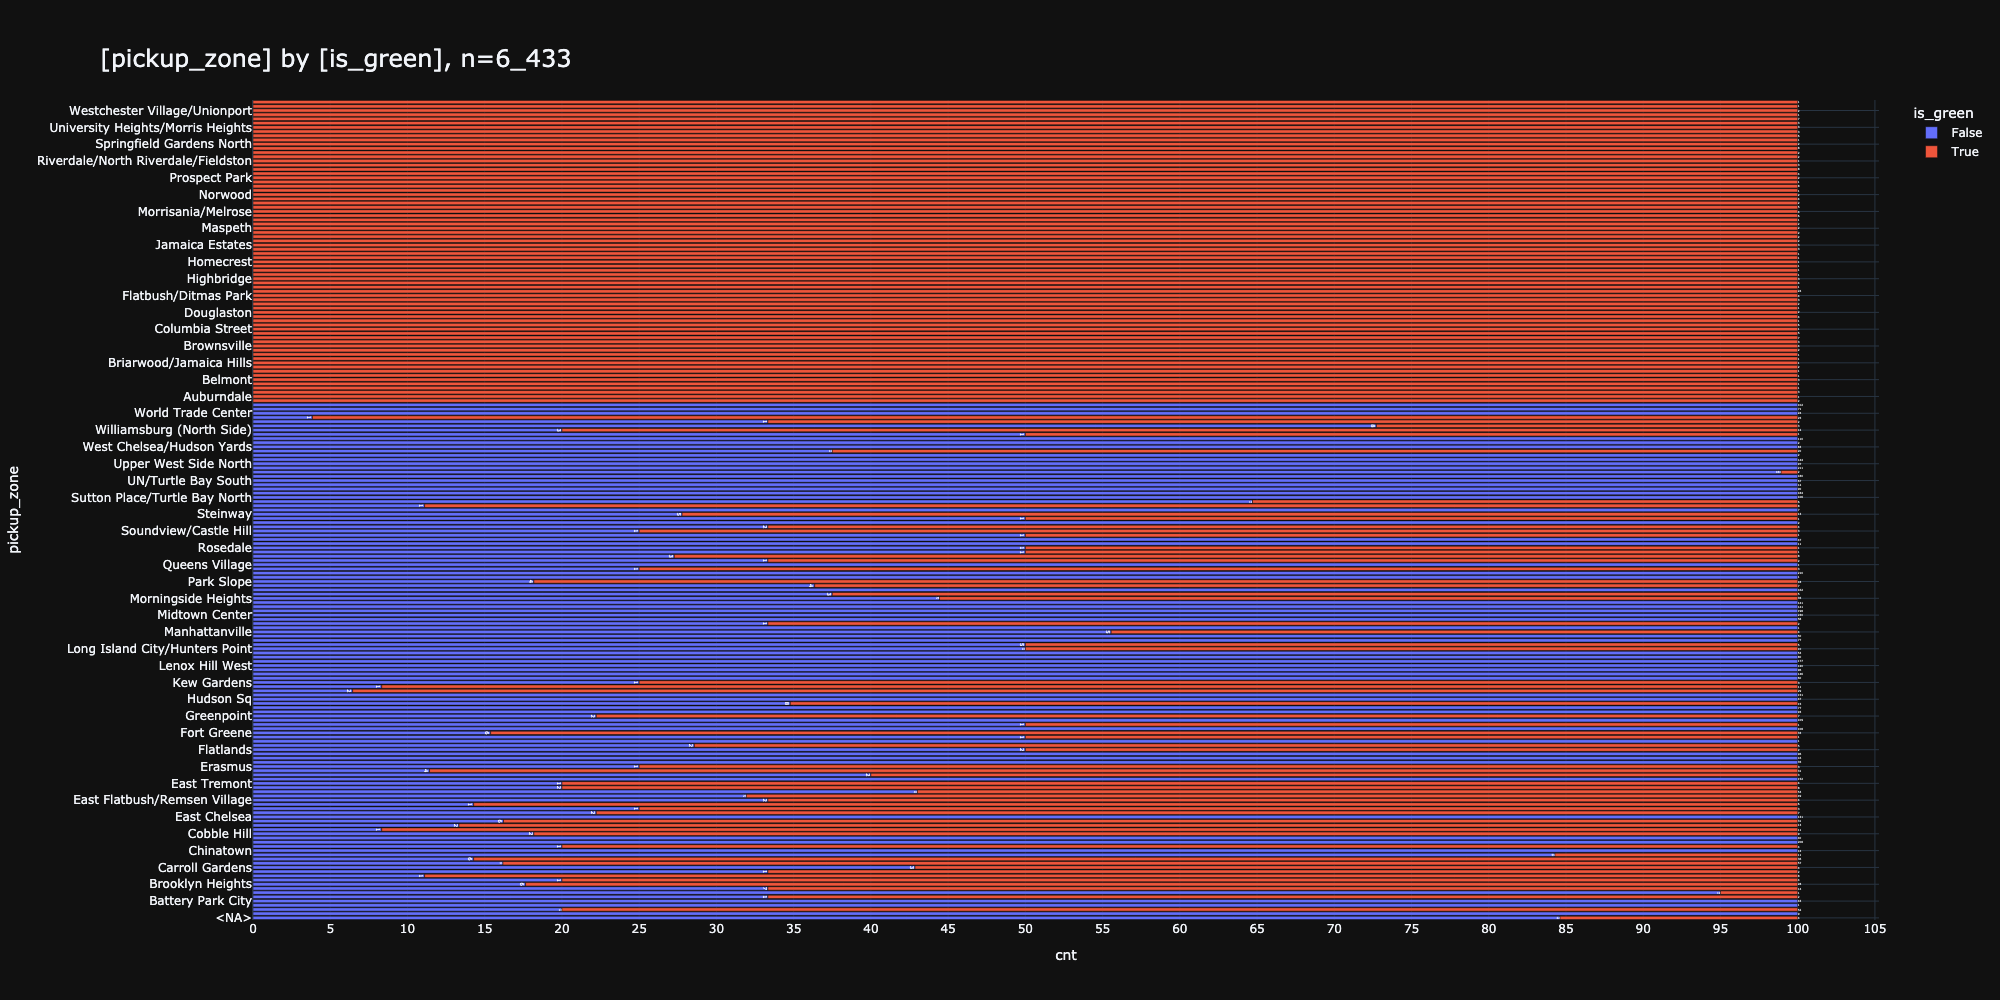

In [ ]:
from pathlib import Path
_df = df
_df['is_green']=_df['color'].apply(lambda x: x=='green')

_=pls.plot_stacked_bars(
    _df[["is_green", "pickup_zone"]][:15000],
    swap=True,
    orientation="h",
    normalize=False,
    relative=True,
    height=1000,
    # png_path=Path("box2.png"),
)

## boxes

In [ ]:
pls.plot_box(
    df.distance,
    height=400,
    violin=False,
    x_min=-2,
    x_max=50,
    # summary = False
)

In [ ]:
_df=df[['color','distance']]
_df['is_green']=_df['color'].apply(lambda x: x=='green')
pls.plot_boxes(_df[['is_green','distance']], height=700, png_path=Path("box3.png"))
_df
# pd.api.types.is_bool_dtype(_df['is_green'])

## bars

In [ ]:
import os, sys
import seaborn as sb
import pandas as pd
from importlib.metadata import version
print(f'seaborn: {version("seaborn")}')
from matplotlib import pyplot as plt

from pandas_plots import tbl, pls, ven, hlp
# from pandas_plots.tbl import *

df = sb.load_dataset('taxis')
os.environ['THEME'] = 'light'
df[:3]

In [ ]:
_df=df[["payment","fare"]]
# _df=df["color"]
lol = pls.plot_bars(_df, orientation="v", normalize=True, use_ci=False, precision=0, dropna=True, png_path=Path("box4.png"))
# display(lol)

In [ ]:
_df = df["distance"]
# _df#.to_frame()
# _df=df[["fare","distance"]]
pls.plot_histogram(
    _df,
    height=800,
    width=1600,
    precision=0,
    orientation="v",
    histnorm="",
    nbins=0,
    # barmode="overlay",
    renderer="png",
    png_path=Path("box5.png"),
)

In [ ]:
# px.histogram(
#     # df[["fare","passengers"]],
#     df[["fare"]],
#     histnorm="",
#     nbins=0,
#     text_auto=True,
#     marginal="",
#     # barmode="",
#     height=500,
#     width=1200,
# )

In [ ]:
_df = df[["fare", "passengers"]]
# pls.plot_joint(_df, precision=0, size=15, kind="reg", caption="")
pls.plot_joint(_df, precision=0, size=15, kind="hex", png_path=Path("box6.png"))
# pls.plot_joint(_df, precision=0, size=5, kind="kde",)
# pls.plot_joint(_df, precision=0, size=5, kind="hist",)

In [ ]:
_df = df[["fare", "passengers"]]
# sb.set_theme(
#     rc={
#         "axes.facecolor": "lightgray",
#         "figure.facecolor": "cornflowerblue",
#     },
#     palette="tab10"
# )
plt.style.use("dark_background")
# plt.style.use("dark_background")
# fig = 
sb.jointplot(
    x=_df.columns[0],
    y=_df.columns[1],
    data=_df,
    height=5,
    kind="kde",
    ratio=10,
    # marginal_ticks=True,
    # color='k',
    palette="tab10",
    # color="black",
    fill=True,
    cmap="rocket",
    # cmap="bone_r",
    title="lol"
)
# plt.show()

In [ ]:
# sys.exit()

## barcode

In [ ]:
from pandas_plots import hlp
url="https://github.com/robert-koch-institut/Bundesweiter_klinischer_Krebsregisterdatensatz-Datenschema_und_Klassifikationen"
# url="http://google.com"

# hlp.create_barcode_from_url(
#     url=url,
#     output_path=".local/zfkd-repo.png",
#     show_image=True,
# )

## misc

In [ ]:
# df
# from pandas_plots import hlp
hlp.add_datetime_columns(df,"dropoff")
# df

In [ ]:
import os, sys
import seaborn as sb
import pandas as pd
from importlib.metadata import version
print(f'seaborn: {version("seaborn")}')
from pandas_plots import tbl, pls, ven, hlp
# from pandas_plots.tbl import *

df = sb.load_dataset('taxis')
os.environ['THEME'] = 'dark'

In [ ]:
lol="""
The most important themes of the draft referendum are:
1. Improving the use of health data for research and innovation, particularly through the establishment of a National Data Access Point;
2. Enhancing the coordination and networking of different stakeholders involved in health data management;
3. Expanding the scope of the General Data Protection Regulation (GDPR) to cover all areas of healthcare;
4. Providing better access to health data for patients and researchers, including through the development of a new law on health data protection;
5. Facilitating the exchange of health data between different countries and regions, particularly within the European Union (EU);
6. Ensuring that data are used in a way that promotes sustainable development and achieves the United Nations' Sustainable Development Goals (SDGs)."""

In [ ]:
print(
hlp.wrap_text(
    text=lol,
    # max_items_in_line=40,
    use_sep=True,
    use_apo=True,
)
)